To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

### Unsloth

In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.3: Fast Gemma3 patching. Transformers: 4.53.2.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 2. Max memory: 47.438 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We now add LoRA adapters for parameter efficient fine-tuning, allowing us to train only 1% of all model parameters efficiently.

**[NEW]** We also support fine-tuning only the vision component, only the language component, or both. Additionally, you can choose to fine-tune the attention modules, the MLP layers, or both!

In [2]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


<a name="Data"></a>
### Data Prep
We'll use a sampled dataset of handwritten math formulas. The objective is to convert these images into a computer-readable format—specifically LaTeX—so they can be rendered. This is particularly useful for complex expressions.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [3]:
from datasets import load_dataset
ds = load_dataset(
    "CADCODER/GenCAD-Code",
    num_proc=16,
    split=["train", "test"],
    cache_dir="./Volumes/BIG-DATA/HUGGINGFACE_CACHE",
)
dataset = ds[0].take(10_000)  # Use the training split

Let's take an overview of the dataset. We'll examine the second image and its corresponding caption.

In [4]:
dataset

Dataset({
    features: ['image', 'deepcad_id', 'cadquery', 'token_count', 'prompt', 'hundred_subset'],
    num_rows: 10000
})

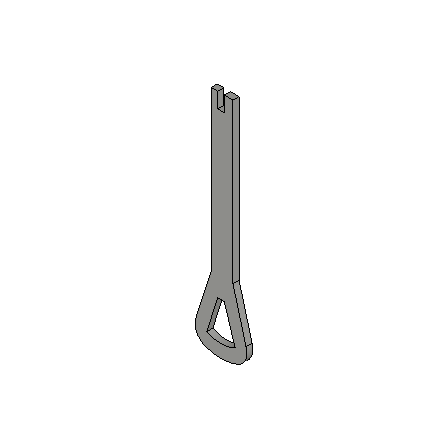

In [5]:
dataset[2]["image"]

In [6]:
print(dataset[2]["cadquery"])

import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.1015625, 0.0, -0.046875), cq.Vector(1.0, 6.123233995736766e-17, -6.123233995736766e-17), cq.Vector(6.123233995736766e-17, -1.0, 6.123233995736766e-17)))
loop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0019490941863378162, -0.04433658679437616), (0.03355263157894737, -0.07549342105263158)).threePointArc((0.09646381578947369, -0.08720656501962193), (0.159375, -0.07549342105263158)).threePointArc((0.19097853739260956, -0.044336586794376284), (0.19292763157894738, 0.0)).lineTo(0.14259868421052632, 0.18453947368421053).lineTo(0.14259868421052632, 0.796875).lineTo(0.10904605263157895, 0.796875).lineTo(0.10904605263157895, 0.7381578947368421).lineTo(0.08388157894736842, 0.7381578947368421).lineTo(0.08388157894736842, 0.796875).lineTo(0.0587171052631579, 0.796875).lineTo(0.0587171052631579, 0.18453947368421053).lineTo(0.0, 0.0).close()
loop1=wp_sketch0.moveTo(0.0, 0.0).threePointArc((

In [7]:
print(dataset[2]["prompt"])

Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words.


We can also render LaTeX directly in the browser!

In [8]:
from IPython.display import display, Math, Latex

To format the dataset, all vision fine-tuning tasks should follow this format:

```python
[
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
]
```

In [9]:
instruction = "Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words."

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": sample["prompt"]},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["cadquery"]}]},
    ]
    return {"messages": conversation}
pass

Let's convert the dataset into the "correct" format for finetuning:

In [10]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [11]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=448x448>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'import cadquery as cq\n# Generating a workplane for sketch 0\nwp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.015625, -0.0078125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))\nloop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0007948582418457166, -0.0019189575476279677), (0.0027138157894736844, -0.0027138157894736844)).lineTo(0.021217105263157895, -0.0027138157894736844).threePointArc((0.022787161438489866, -0.00206347722796355), (0.0234375, -0.000493421052631579)).lineTo(0.0234375, 0.018256578947368422).threePointArc((0.02283825686147997, 0.019949990385858287), (0.021217105263157895, 0.020723684210526318)).lineTo(0.00

Lets take the Gemma 3 instruction chat template and use it in our base model

In [12]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3"
)

Before fine-tuning, let us evaluate the base model's performance. We do not expect strong results, as it has not encountered this chat template before.

In [13]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[2]["image"]
instruction = "Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words."

messages = [
    {
        "role": "user",
        "content": [{"type": "text", "text": instruction}, {"type": "image"}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words.

<start_of_image><start_of_image> orderEntry:type:text
orderEntry:type:text
orderEntry:type:text
orderEntry:type:text
orderEntry:type:text
orderEntry:type:textorderEntry:type:text
orderEntry:type:text
orderEntry:type:textorderEntry:type:text
orderEntry:type:text
orderEntry:type:textorderEntry:type:text
orderEntry:type:text
orderEntry:type:textorderEntry:type:text
orderEntry:type:text
orderEntry:type


You can see it's absolutely terrible! It doesn't follow instructions at all

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [14]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 100,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_seq_length = 2048,
    )
)

In [15]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX A6000. Max memory = 47.438 GB.
4.721 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,1.077000
2,1.167200
3,1.179100
4,1.210700
5,0.674300
6,0.813100
7,0.752000
8,0.572900
9,0.732100
10,0.501900


In [17]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

784.0924 seconds used for training.
13.07 minutes used for training.
Peak reserved memory = 8.387 GB.
Peak reserved memory for training = 3.666 GB.
Peak reserved memory % of max memory = 17.68 %.
Peak reserved memory for training % of max memory = 7.728 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can modify the instruction and input—just leave the output blank.

We'll use the best hyperparameters for inference on Gemma: `top_p=0.95`, `top_k=64`, and `temperature=1.0`.

In [18]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[200]["image"]
instruction = "Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.296875, -0.03125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.2734375, 0.0).threePointArc((0.546


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, use Hugging Face’s `push_to_hub` for online saving, or `save_pretrained` for local storage.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [19]:
model.save_pretrained("outputs/lora_model")  # Local saving
processor.save_pretrained("outputs/lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

['outputs/lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [20]:
if False:
    from unsloth import FastVisionModel

    model, processor = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,  # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

FastVisionModel.for_inference(model)  # Enable for inference!

sample = dataset[1]
image = sample["image"].convert("RGB")
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": sample["prompt"],
            },
            {
                "type": "image",
            },
        ],
    },
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.515625, -0.203125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.4836260000000001, 0.0


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [21]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if True: model.save_pretrained_merged("outputs/unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")

Found HuggingFace hub cache directory: /data/home/eak/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [02:28<02:28, 148.51s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [04:22<00:00, 131.49s/it]


And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
